In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time

import numpy as np
import skimage.transform
import skimage.measure
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import rasterio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.feature_extraction.image import extract_patches_2d

import cProfile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

def cum_sum(arr, s):
    cumsum = torch.cumsum(torch.cumsum(arr,dim=2),dim=3)
    cumsum = F.pad(cumsum,(1,0,1,0),'constant',0)
    tot = cumsum[:,:,:-s,:-s]-cumsum[:,:,s:,:-s]-cumsum[:,:,:-s,s:]+cumsum[:,:,s:,s:]
    return tot

def to_disp(arr):
    arr_c = arr.cpu().numpy()
    arr_c = np.rollaxis(np.squeeze(arr_c),0,3)
    return arr_c

#learns N x N epitome from T, K x K random patches drawn from input image x.
#Applies NIT iterations of the E-M algorithm at scale sc; T*sc^2 patches are sampled.
#e,ev = initial epitome mean and variance. The mean is initialized
#to the uniform image with some small noise, and the variance is initialized to 1
#p holds an array of probabilities of using each part of the epitome

def epitome(x,K,N,T,NIT,sc):
    xFIN = x #added
    #x = F.max_pool2d(x,int(1/sc[0]))
    x = torch.clamp(F.interpolate(x,scale_factor=sc[0]),min=0,max=1)
    _, numDim, SY, SX = x.shape
    TFIN = T #added
    T = int(np.ceil(T*sc[0]**2))
    NFIN = N
    N = int(np.ceil(sc[0]*N))
    #e = mean of image plus noise
    e = torch.zeros((1,numDim,N,N)).to(device)
    ev = torch.ones((1,numDim,N,N)).to(device)/50
    for i in range(numDim):
        e[:,i,:,:] = x[0,i,:,:].std()*torch.randn(N,N).to(device)/100+x[0,i,:,:].mean()
    p = torch.ones((N,N)).to(device)/N**2
    MINP = 1e-7#1e-8 is acceptable
    MINV = 1e-2#1e-6
    #allocate trace of epitome
    etr = torch.zeros((NIT+1,1,numDim,NFIN,NFIN))
    etr[0,:,:,:,:] = F.interpolate(e,[NFIN,NFIN])
    #e = torch.clamp(e,min=0,max=1)
    #ev = torch.clamp(ev,min=MINV)
    #perform NIT iterations of EM algorithm
    for sci in range(len(sc)):
        if sci != 0:
            N = int(np.ceil(sc[sci]*NFIN))
            e = torch.clamp(F.interpolate(e,[N,N]),min=0,max=1).to(device)
            ev = torch.clamp(F.interpolate(ev,[N,N]),min=MINV).to(device)
            p = torch.ones((N,N)).to(device)/N**2
            #x = F.max_pool2d(xFIN,int(1/sc[sci]))
            x = torch.clamp(F.interpolate(xFIN,scale_factor=sc[sci]),min=0,max=1).to(device)
            T = int(np.ceil(sc[sci]**2*TFIN))
        sumP = torch.zeros((N,N),dtype=torch.float).to(device)
        sumPy = torch.zeros((numDim,N,N),dtype=torch.float).to(device)
        sumPy2 = torch.zeros((numDim,N,N),dtype=torch.float).to(device)
        ewrap = torch.zeros((numDim,N+K-1,N+K-1),dtype=torch.float).to(device)
        evwrap = torch.zeros((numDim,N+K-1,N+K-1),dtype=torch.float).to(device)
        SY = x.shape[2]
        SX = x.shape[3]
        patchnum = min(T,(SY-K)**2)
        ytemp = np.rollaxis(extract_patches_2d(torch.squeeze(x).permute(1,2,0),(K,K),max_patches=patchnum),3,1)
        y = torch.from_numpy(ytemp).float().to(device)
        for nit in range(NIT):
            #glues together borders of e
            ewrap[:,:N,:N] = e;
            ewrap[:,N:,:] = ewrap[:,:K-1,:]
            ewrap[:,:,N:] = ewrap[:,:,:K-1]
            evwrap[:,:N,:N] = ev
            evwrap[:,N:,:] = evwrap[:,:K-1,:]
            evwrap[:,:,N:] = evwrap[:,:,:K-1]
            evwrapi = 1./evwrap
            print(ewrap.device,evwrap.device,evwrapi.device)
            # E STEP
            sumP[:,:] = 0
            sumPy[:,:,:] = 0
            sumPy2[:,:,:] = 0
            for t in range(patchnum):
                yc = y[t,:,:,:]
                yct = torch.unsqueeze(torch.flip(yc,[1,2]),0)
                print(yct.device)
                #compute posterior over patch location
                lP = torch.log(p).to(device) #added
                tmp1 = torch.squeeze(F.conv2d(torch.unsqueeze(evwrapi,0),yct**2))
                tmp2 = torch.squeeze(F.conv2d(torch.unsqueeze(ewrap*evwrapi,0),yct))
                tmp3 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(ewrap**2*evwrapi,0),K)),dim=0)
                tmp4 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(torch.log(evwrap),0),K)),dim=0)
                lP -= .5*(tmp4+tmp1-2*tmp2+tmp3)
                P = torch.exp(lP-torch.max(lP))+MINP
                P /= torch.sum(P)
                #update mean and variance
                tmp = P.view(1,1,N,N).to(device)
                tmp = F.pad(tmp,(K-1,K-1,K-1,K-1),'constant',0)
                tmp = torch.squeeze(cum_sum(tmp,K))
                tmp[:,:K-1] += tmp[:,N:]
                tmp[:K-1,:] += tmp[N:,:]
                sumP += tmp[:N,:N]
                tmpP = F.pad(P.view(1,1,N,N),(K-1,K-1,K-1,K-1),'constant',0)
                #tmpP = torch.unsqueeze(torch.unsqueeze(F.pad(P,(K-1,K-1,K-1,K-1),'constant',0),0),0)
                yctmp = torch.unsqueeze(yc,1)
                tmp = torch.squeeze(F.conv2d(tmpP,yctmp))
                tmp[:,:,:K-1] += tmp[:,:,N:]
                tmp[:,:K-1,:] += tmp[:,N:,:]
                sumPy += tmp[:,:N,:N]
                tmp = torch.squeeze(F.conv2d(tmpP,yctmp**2))
                tmp[:,:,:K-1] += tmp[:,:,N:]
                tmp[:,:K-1,:] += tmp[:,N:,:]
                sumPy2 += tmp[:,:N,:N]
            torch.cuda.empty_cache()
            #M STEP
            #p = sumP/torch.sum(sumP)#commented out
            e[0,:,:,:] = sumPy/sumP
            if nit>10 or sci>0:
                ev[0,:,:,:] = sumPy2/sumP - 2*e[0,:,:,:]*sumPy/sumP+e[0,:,:,:]**2
            ev = torch.clamp(ev,min=MINV)
            etemp = F.interpolate(e,[NFIN,NFIN])
            etr[nit+1,:,:,:] = etemp
            fig=plt.figure(figsize=(15,5))
            fig.add_subplot(131)
            plt.axis('off')
            td = to_disp(etemp[:,:3,:,:])
            plt.imshow(td)
            plt.title(str(N)+'x'+str(N)+' epitome')
            fig.add_subplot(132)
            plt.axis('off')
            plt.imshow(p,cmap='hot',interpolation='nearest')
            plt.title('mixing proportions')
            fig.add_subplot(133)
            plt.axis('off')
            curr_heat = np.sum(np.squeeze(ev.cpu().numpy()),axis=0)
            plt.imshow(curr_heat,cmap='hot',interpolation='nearest')
            plt.title('variances, max='+str(max(curr_heat.flatten())))
            plt.show()
            plt.close()   
    return e,ev,p,etr

[2 3 4 5 6]


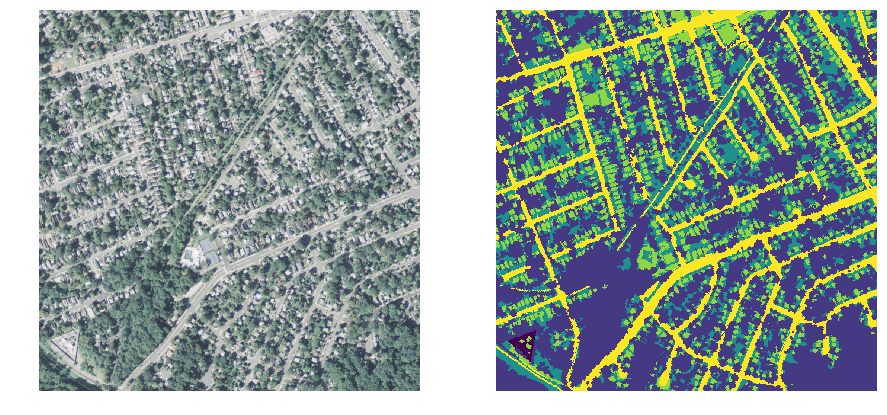

CPU times: user 2.75 s, sys: 633 ms, total: 3.38 s
Wall time: 4.09 s


In [46]:
%%time
p = pd.read_csv("big_lc_paths.csv", header=None)
paths = p[0].tolist()
palette = np.array([[0,0,0],[0,153,51],[0,102,255],[153,102,51],[255,153,0],[255,255,0],[204,102,153]])

tile = 0
naip_tile = rasterio.open("/mnt/blobfuse/esri-naip/"+paths[tile][:-7]+".mrf",'r')
naip = naip_tile.read().astype(float)[:,:1024,:1024]/255.
naip_tile.close()

lc_tile = rasterio.open('/mnt/blobfuse/resampled-lc/'+paths[tile],'r')
lc = np.squeeze(lc_tile.read())[:1024,:1024]
lc_tile.close()
print(np.unique(lc))
lc[lc==1]=10
lc[lc==2]=1
lc[lc==10]=2
lc[lc==4]=0
lc[lc==15]=4
fig=plt.figure(figsize=(15,10))
fig.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(np.rollaxis(naip,0,3)[:,:,:3])
fig.add_subplot(1,2,2)
plt.axis('off')
plt.imshow(lc)
plt.show()
plt.close()

trIM = np.zeros((10,naip.shape[1],naip.shape[2]),dtype=float)
trIM[:4,:,:] = naip
for i in range(6):
    trIM[4+i,:,:] = (lc==(i+1))
trIM = np.expand_dims(trIM,axis=0)
trIMtorch = torch.from_numpy(trIM).float().to(device)
tsIMtorch = trIMtorch

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


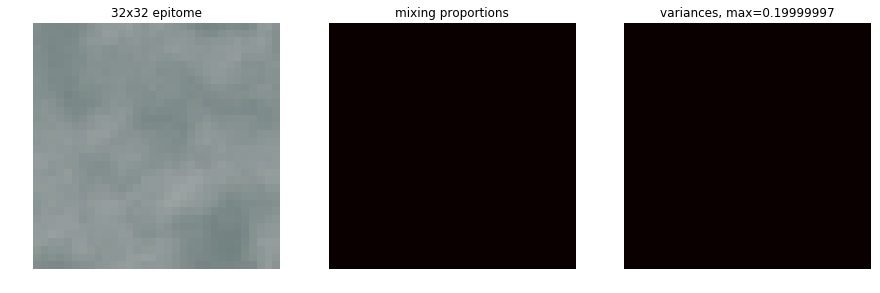

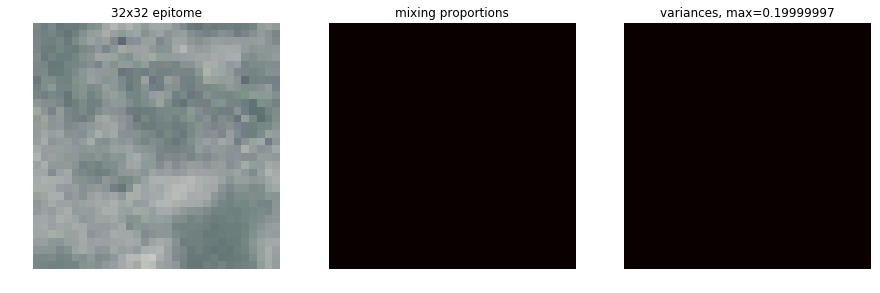

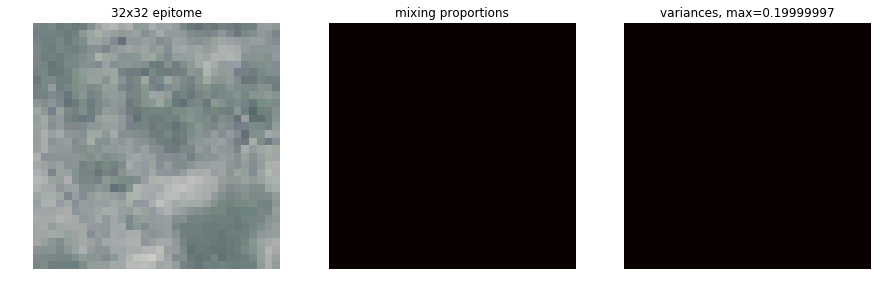

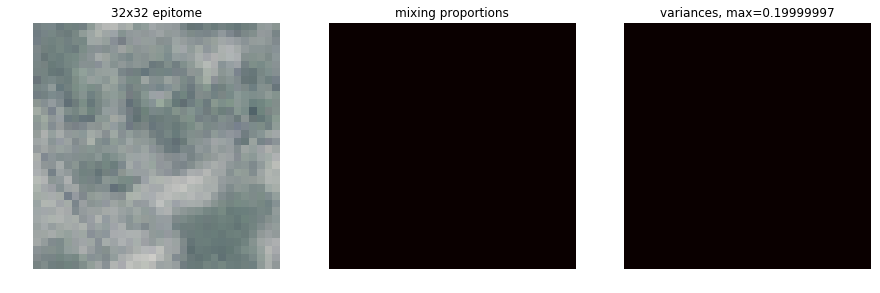

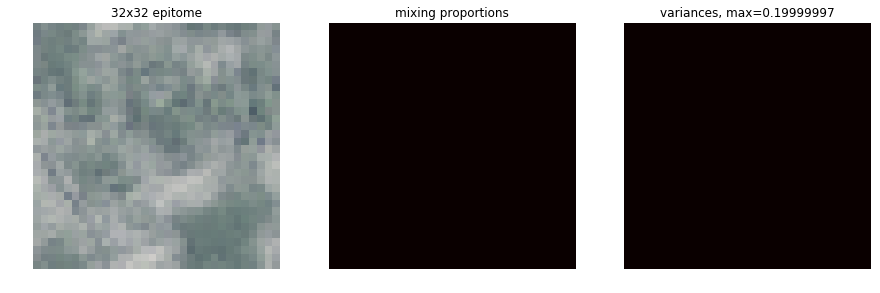

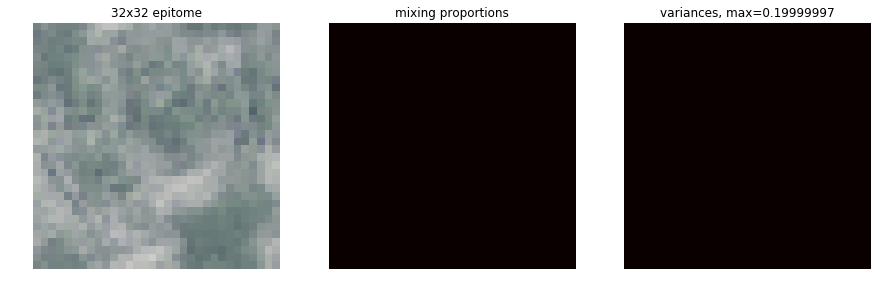

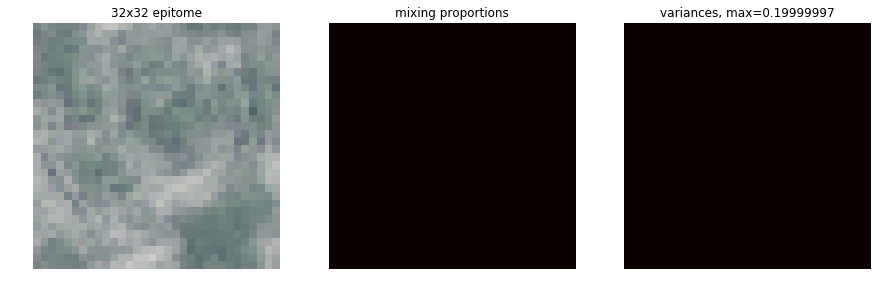

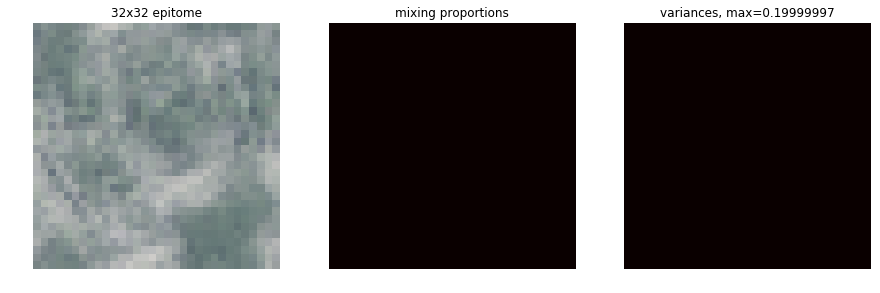

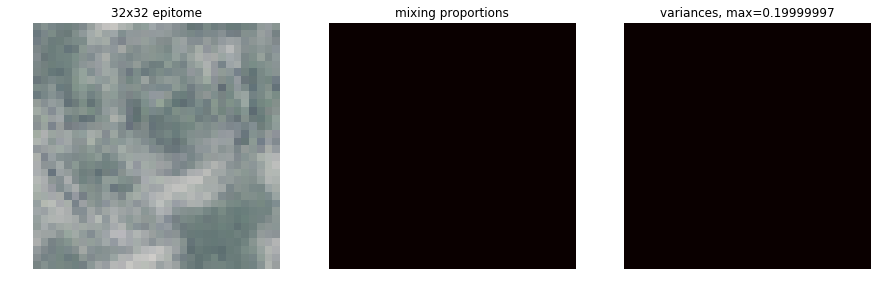

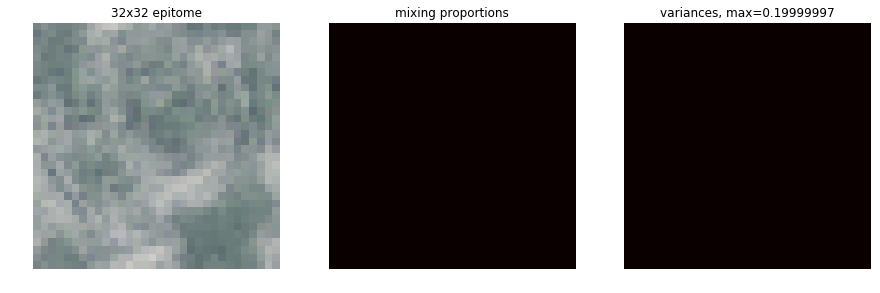

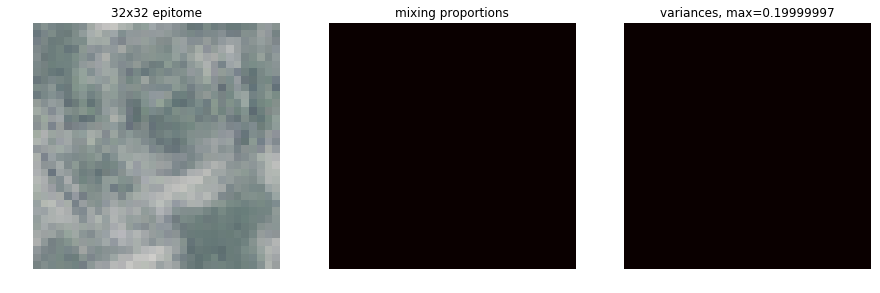

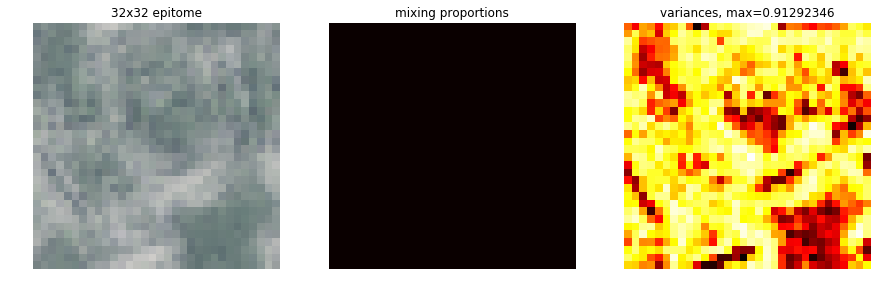

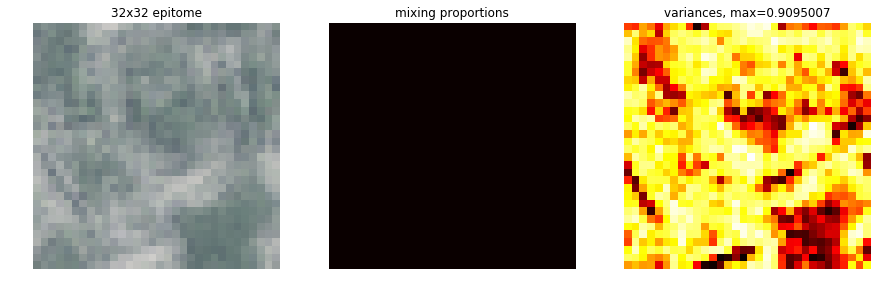

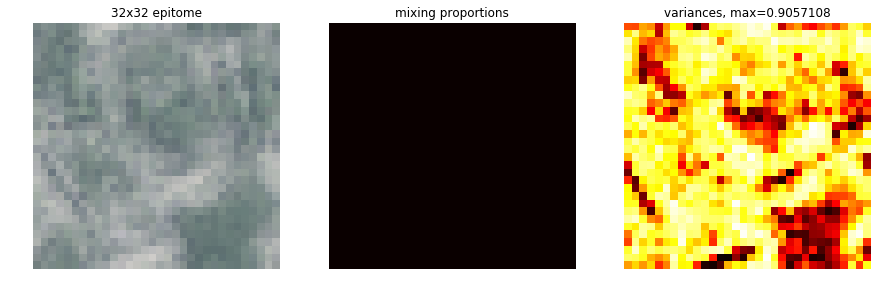

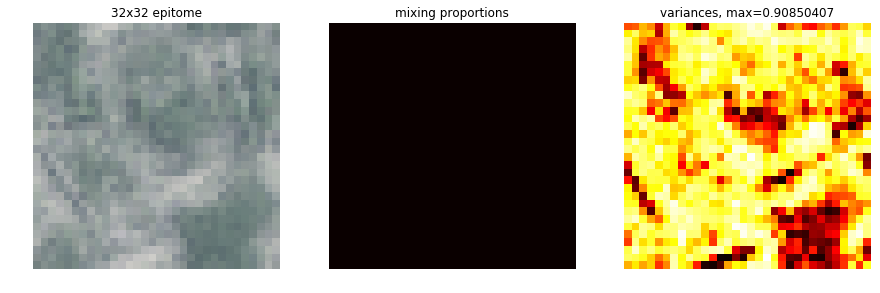

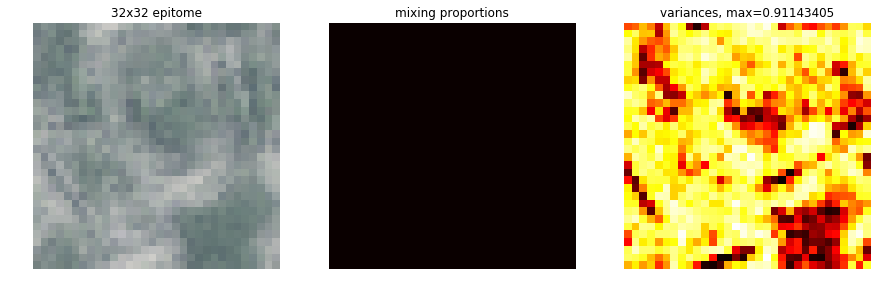

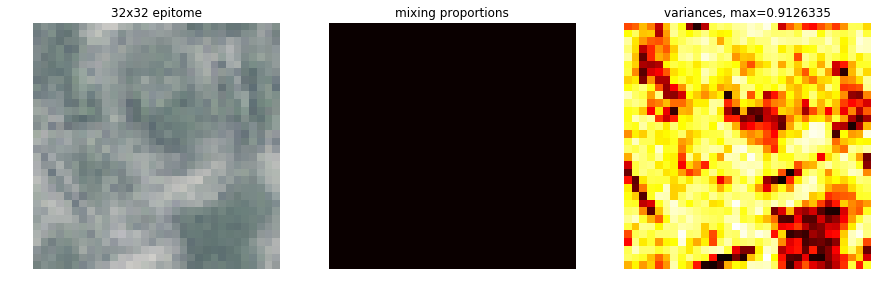

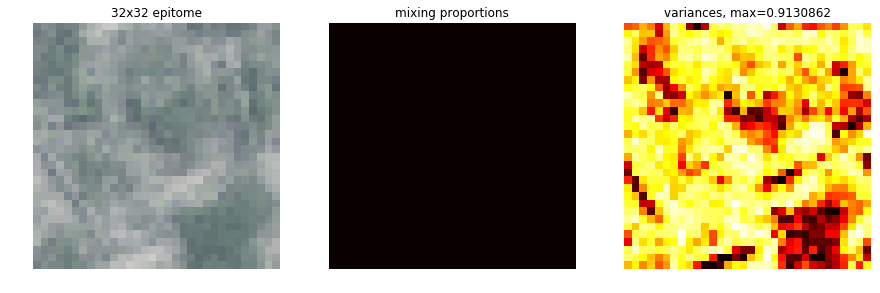

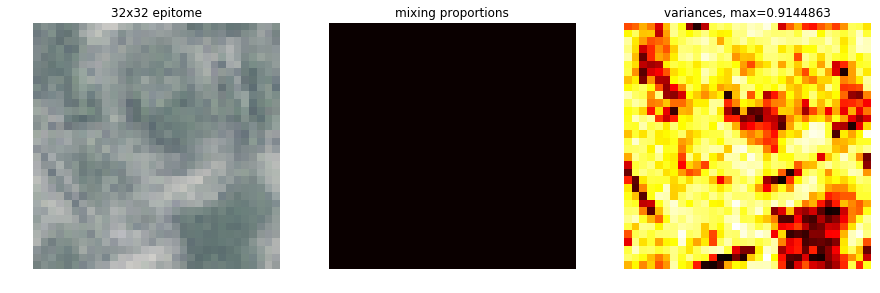

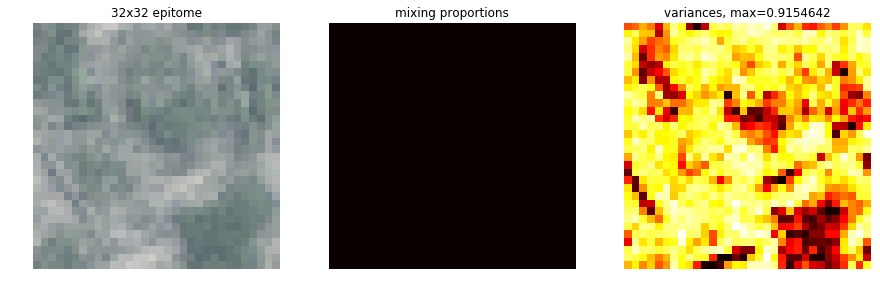

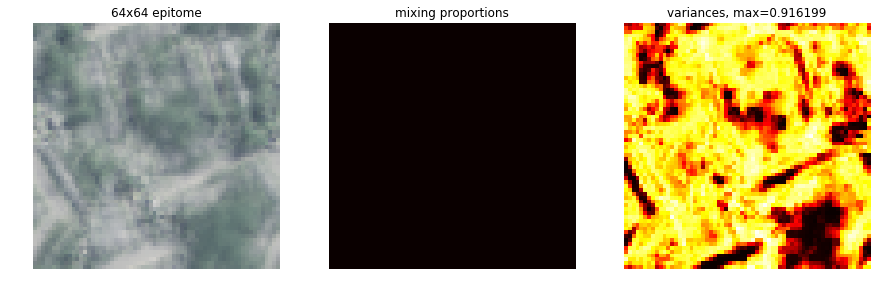

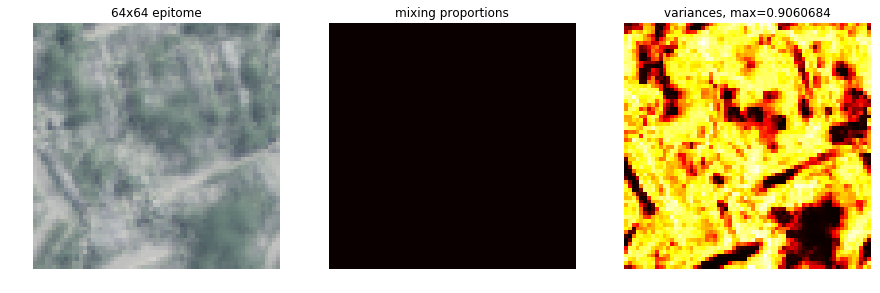

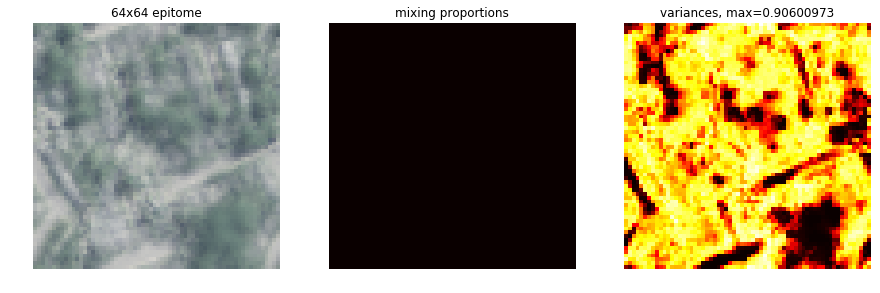

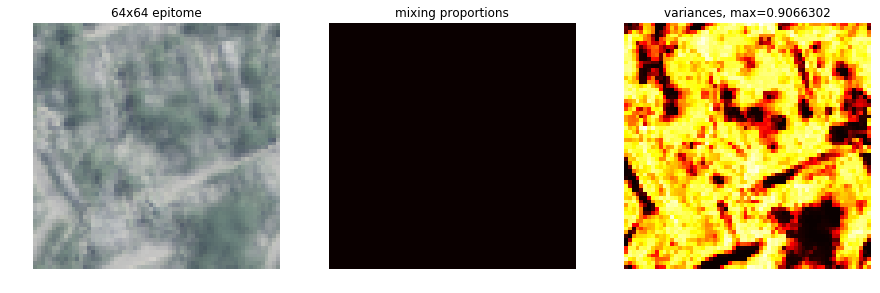

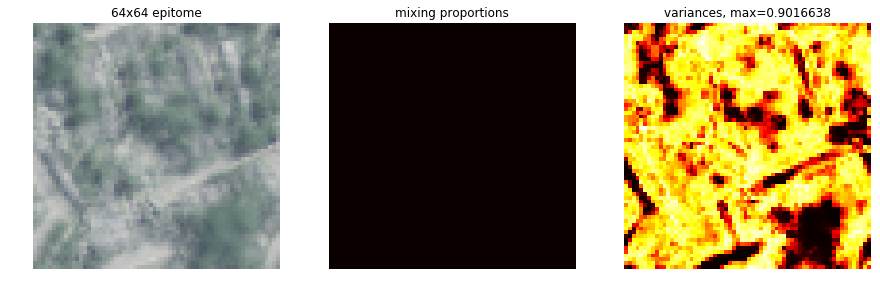

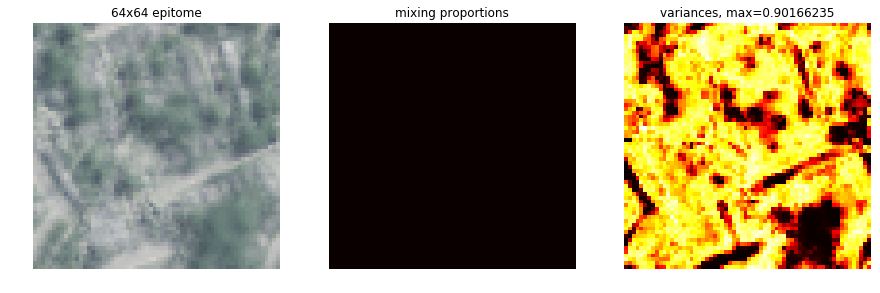

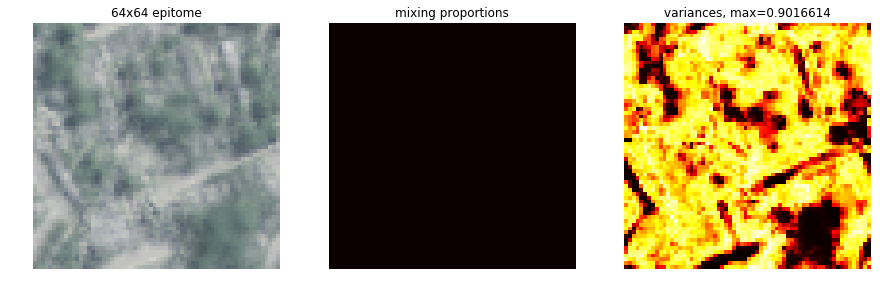

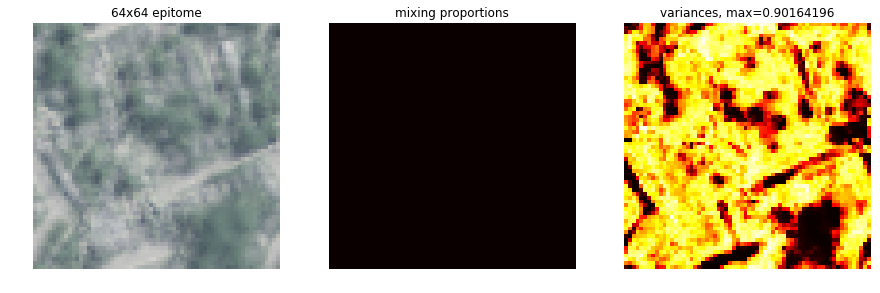

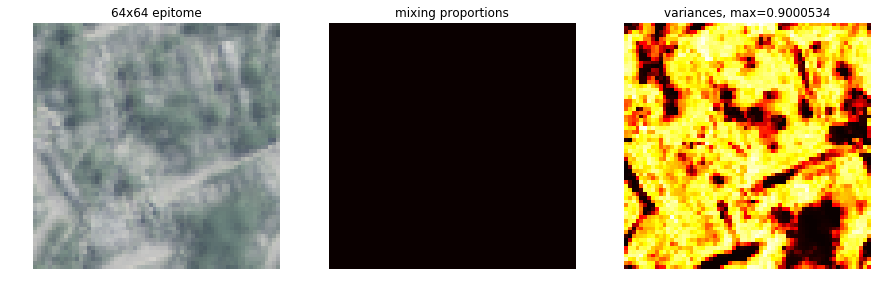

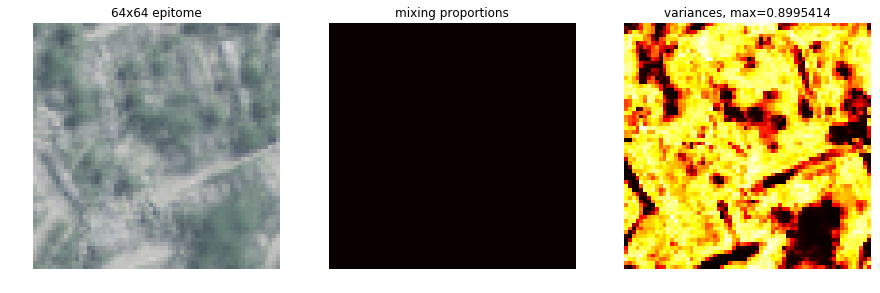

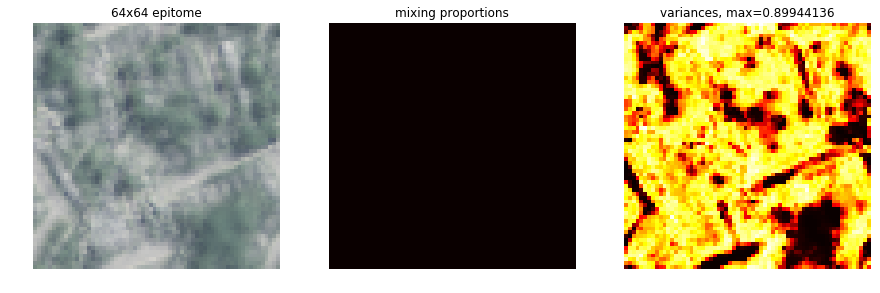

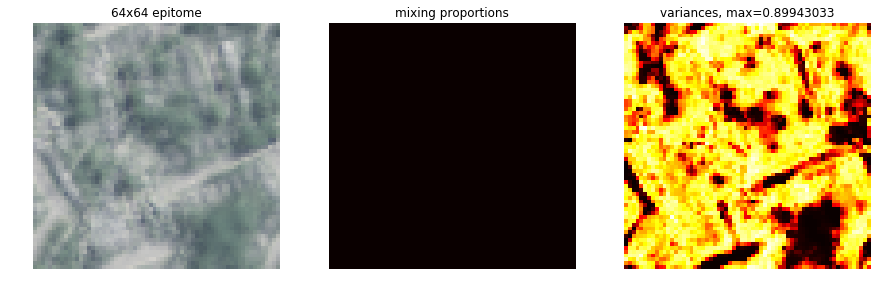

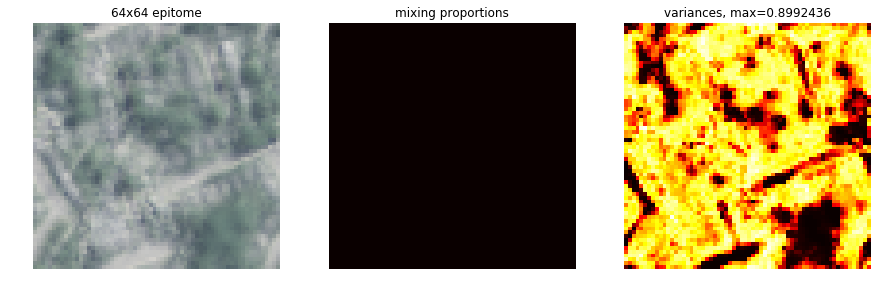

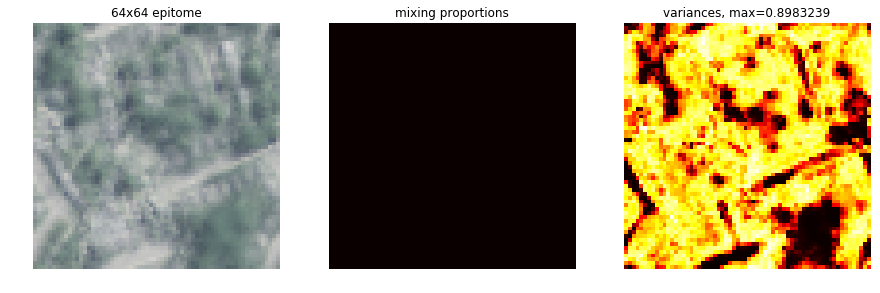

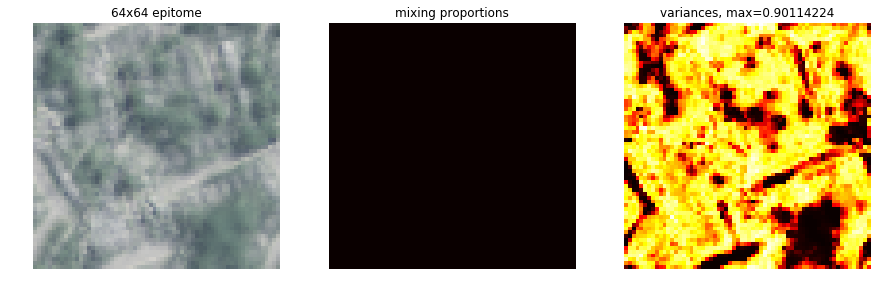

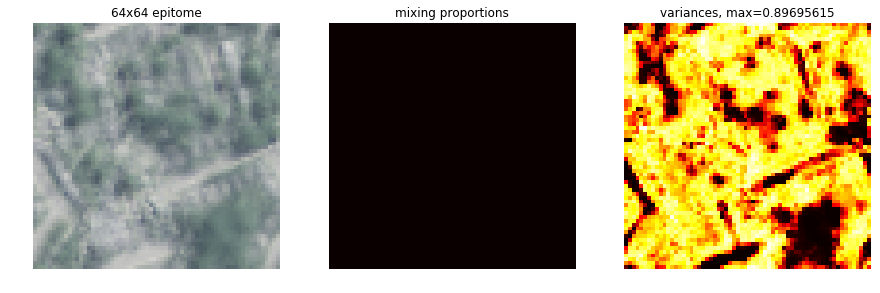

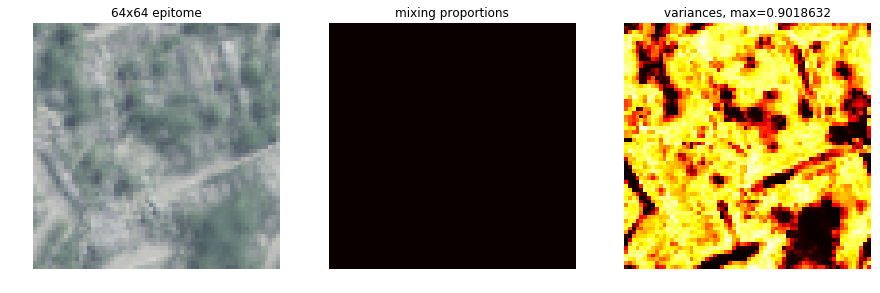

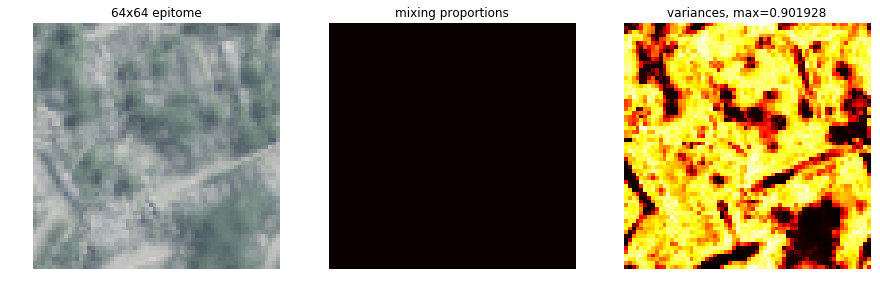

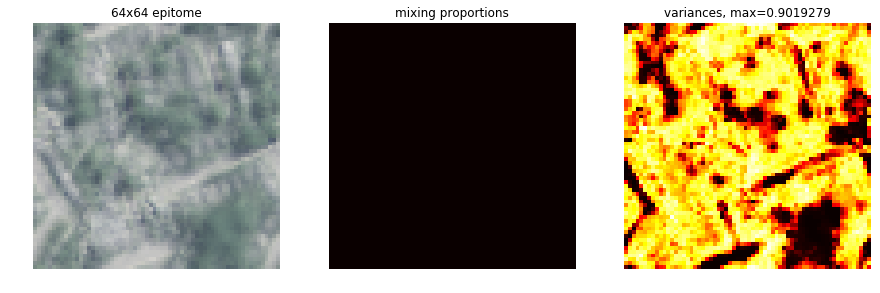

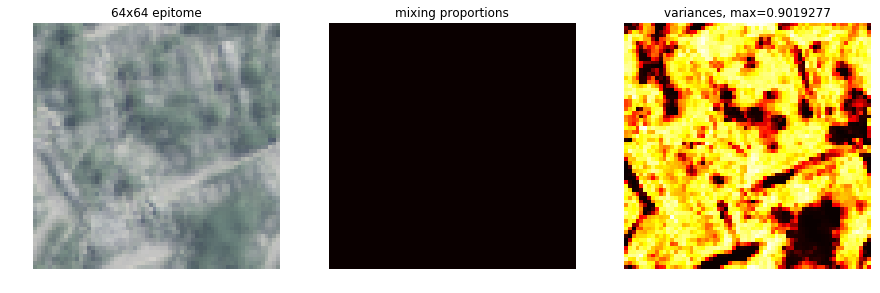

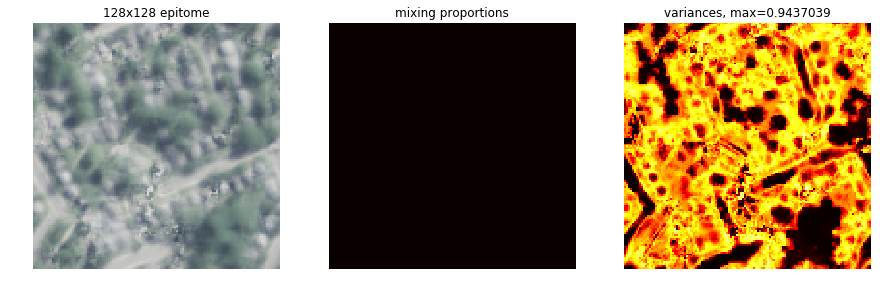

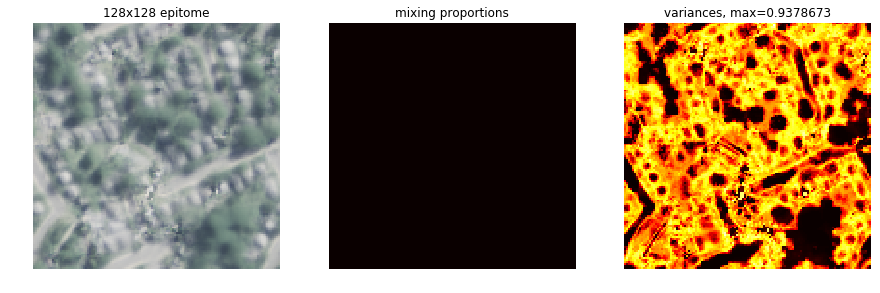

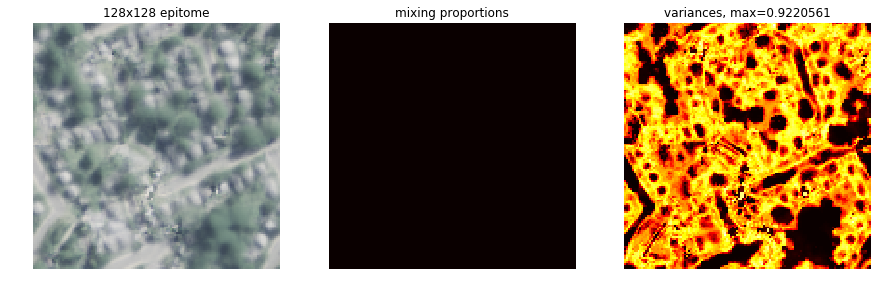

         27165442 function calls (27016201 primitive calls) in 363.170 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  363.170  363.170 {built-in method builtins.exec}
        1    0.000    0.000  363.170  363.170 <string>:1(<module>)
        1   86.829   86.829  363.170  363.170 <ipython-input-67-379e23d571b4>:20(epitome)
   374051   38.007    0.000   84.316    0.000 <ipython-input-67-379e23d571b4>:3(cum_sum)
   124683   74.104    0.001   74.104    0.001 {built-in method max}
   623416    2.084    0.000   61.195    0.000 functional.py:2112(pad)
   623416    5.825    0.000   58.710    0.000 {built-in method apply}
   623416   13.669    0.000   52.885    0.000 padding.py:12(forward)
   498734   30.875    0.000   30.875    0.000 {built-in method conv2d}
   374050   13.582    0.000   13.582    0.000 {built-in method sum}
   124684   12.922    0.000   12.922    0.000 {built-in method flip}
   7481

      129    0.001    0.000    0.031    0.000 _subplots.py:131(update_params)
       86    0.000    0.000    0.031    0.000 transforms.py:2005(clear)
 1290/645    0.004    0.000    0.031    0.000 transforms.py:2426(frozen)
     8686    0.031    0.000    0.031    0.000 {built-in method numpy.core.multiarray.concatenate}
      903    0.008    0.000    0.030    0.000 {built-in method matplotlib._path.get_path_extents}
      129    0.002    0.000    0.030    0.000 gridspec.py:456(get_position)
       43    0.001    0.000    0.030    0.001 backend_bases.py:153(new_figure_manager)
      129    0.001    0.000    0.030    0.000 axis.py:1939(_update_offset_text_position)
     1763    0.008    0.000    0.029    0.000 transforms.py:436(bounds)
     3999    0.029    0.000    0.029    0.000 {method 'astype' of 'numpy.ndarray' objects}
     1161    0.002    0.000    0.028    0.000 transforms.py:1882(transform_point)
     4128    0.004    0.000    0.028    0.000 axis.py:1515(convert_units)
    17802 

In [ ]:
%%time
#no longer accepts initializations of e or ev
cProfile.run('e,ev,p,etr=epitome(trIMtorch,9,256,50000,20,[.125,.25,.5,1])',sort='cumtime')
torch.cuda.empty_cache()

In [17]:
#Replaces the epitome (e,ev) of an image by another epitome image (emod)
#keeping the mapping intact. The routine can be used to edit images or to
#preprocess by coloring the image accoring to the image (see the segmentation
#part of the web page for more info). K specifies the patch size to use in 
#mapping inference and SPC defines the patch spacing.

def reconstruct(x,K,e,ev,emod,SPC):
    _,NoCh1,Ny,Nx = x.shape
    NoCh2 = emod.shape[0]
    #print(NoCh1,NoCh2)
    if NoCh1 == 1:
        x = torch.stack((x,x,x),dim=0)
        print(x.shape)
    NoCh1,N,Ny = e.shape
    SY = x.shape[2]
    SX = x.shape[3]
    ewrap = torch.zeros((NoCh1,N+K-1,N+K-1)).to(device)
    evwrap = torch.zeros((NoCh1,N+K-1,N+K-1)).to(device)
    MINP = 1e-8
    MINV = 1e-2
    ewrap[:,:N,:N] = e
    ewrap[:,N:,:] = ewrap[:,:K-1,:]
    ewrap[:,:,N:] = ewrap[:,:,:K-1]
    evwrap[:,:N,:N] = ev
    evwrap[:,N:,:] = evwrap[:,:K-1,:]
    evwrap[:,:,N:] = evwrap[:,:,:K-1]
    evwrapi = 1./evwrap
    tmp3 = torch.squeeze(cum_sum(torch.unsqueeze(ewrap**2*evwrapi,0),K))
    tmp4 = torch.squeeze(cum_sum(torch.unsqueeze(torch.log(evwrap),0),K))
    #print(tmp3.shape,tmp4.shape)
    emodwrap = torch.zeros((NoCh2,N+K-1,N+K-1)).to(device)
    emodwrap[:,:N,:N] = emod
    emodwrap[:,N:,:] = emodwrap[:,:K-1,:]
    emodwrap[:,:,N:] = emodwrap[:,:,:K-1]
    z = torch.zeros((NoCh2,SY,SX)).to(device)
    cnt = torch.zeros((SY,SX)).to(device)
    ixt = 0
    iyt = 0
    #for each patch of the input, find the distribution over the epitome positions,
    #and reconstruct the patch in the input image, using the modified epitome.
    for iy in range(0,SY-K+1,SPC):
        print('y index = '+str(iy))
        for ix in range(0,SX-K+1,SPC):
            #watch for indexing errors
            yc = x[:,:,iy:iy+K,ix:ix+K]
            yct = torch.flip(yc,[2,3])
            lP = torch.zeros(tmp4.shape).to(device)#[:,:] = 0
            #print(evwrapi.shape,ewrap.shape,evwrap.shape,yct.shape)
            tmp1 = torch.squeeze(F.conv2d(torch.unsqueeze(evwrapi,0),yct**2))
            tmp2 = torch.squeeze(F.conv2d(torch.unsqueeze(ewrap*evwrap,0),yct))
            lP += -.5*(tmp4+tmp1-2*tmp2+tmp3)
            lP = torch.sum(lP,dim=0)
            P = torch.exp(lP-torch.max(lP))+MINP
            P /= torch.sum(P)
            argmax = torch.argmax(P)
            mxpi = argmax//P.shape[0]
            mxpj = argmax - mxpi*P.shape[0]
            #watch for indexing errors
            newp = emodwrap[:,mxpi:mxpi+K,mxpj:mxpj+K]
            z[:,iy:iy+K,ix:ix+K] += newp 
            cnt[iy:iy+K,ix:ix+K] += 1
            ixt = ix
            iyt = iy
    z = z[:,:iyt+K,:ixt+K]
    cnt = cnt[:iyt+K,:ixt+K]
    z /= cnt
    return z

In [23]:
%%time
xcut = 1000
ycut = 1000
cProfile.run('z2=reconstruct(tsIMtorch[:,:4,:xcut,:ycut],17,e[0,:4,:xcut,:ycut],ev[0,:4,:xcut,:ycut],e[0,4:,:xcut,:ycut],3)')
torch.cuda.empty_cache()

y index = 0
y index = 3
y index = 6
y index = 9
y index = 12
y index = 15
y index = 18
y index = 21
y index = 24
y index = 27
y index = 30
y index = 33
y index = 36
y index = 39
y index = 42
y index = 45
y index = 48
y index = 51
y index = 54
y index = 57
y index = 60
y index = 63
y index = 66
y index = 69
y index = 72
y index = 75
y index = 78
y index = 81
y index = 84
y index = 87
y index = 90
y index = 93
y index = 96
y index = 99
y index = 102
y index = 105
y index = 108
y index = 111
y index = 114
y index = 117
y index = 120
y index = 123
y index = 126
y index = 129
y index = 132
y index = 135
y index = 138
y index = 141
y index = 144
y index = 147
y index = 150
y index = 153
y index = 156
y index = 159
y index = 162
y index = 165
y index = 168
y index = 171
y index = 174
y index = 177
y index = 180
y index = 183
y index = 186
y index = 189
y index = 192
y index = 195
y index = 198
y index = 201
y index = 204
y index = 207
y index = 210
y index = 213
y index = 216
y index = 219
y 

In [24]:
zcpu = z2.cpu().numpy()

In [25]:
zcpu[2]

array([[5.6266290e-01, 3.6496034e-01, 3.2357943e-01, ..., 3.7111086e-01,
        3.2528037e-01, 3.5642204e-01],
       [4.9423051e-01, 3.5515985e-01, 3.2683662e-01, ..., 3.7862059e-01,
        3.3762014e-01, 3.5861814e-01],
       [5.4583234e-01, 4.9684644e-01, 3.7305754e-01, ..., 3.6206889e-01,
        2.7590576e-01, 3.1901205e-01],
       ...,
       [6.7989095e-05, 2.8569824e-01, 3.3331475e-01, ..., 4.6982032e-01,
        5.5363774e-01, 3.8039201e-01],
       [7.5131356e-05, 2.8569448e-01, 4.2102322e-01, ..., 4.2538005e-01,
        4.8518157e-01, 2.7485648e-01],
       [6.6735193e-02, 7.6997533e-02, 2.7778441e-01, ..., 4.9282637e-01,
        4.8700866e-01, 2.3994902e-01]], dtype=float32)

In [26]:
np.savez_compressed('reconstruction2',a=zcpu)

In [26]:
zmax = np.argmax(np.reshape(zcpu,(6,-1)),axis=0)
zre = np.reshape(zmax,(zcpu.shape[1],-1))
zre.shape

(998, 998)

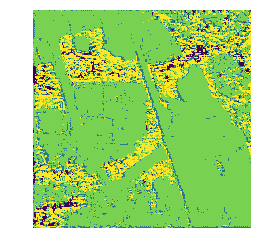

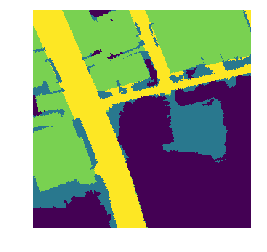

In [27]:
plt.figure()
plt.imshow(zre)
plt.axis('off')
plt.show()
plt.close()
plt.figure()
plt.imshow(lc[:300,:300])
plt.axis('off')
plt.show()
plt.close()